In [2]:
%load_ext autoreload  
%autoreload 2   

In [ ]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

from dataset import UnemployRateDataset, extract_data
from model import HybridLSTMGRU
import evaluation as eval

Dataset Extrait :

- Date : 1983-01 à 2024-12
- Zone : France, USA, United Kingdom, Italie
- Mesure: Taux de chomage mensuel
- Unité: Pourcentage de la population active 
- Ajustemenet : corrigé des variations saisonieres, et des effets de calendrier (data_ocde_corr)
- Sexe: Tout 
- Age: 15 ans et plus 

In [11]:
dataset = pd.read_csv("data_ocde_cor.csv", usecols=["TIME_PERIOD",'REF_AREA', "OBS_VALUE"])

pays_avaliable = dataset["REF_AREA"].unique()
print(pays_avaliable)
pays = "FRA"

['USA' 'ITA' 'FRA' 'GBR']


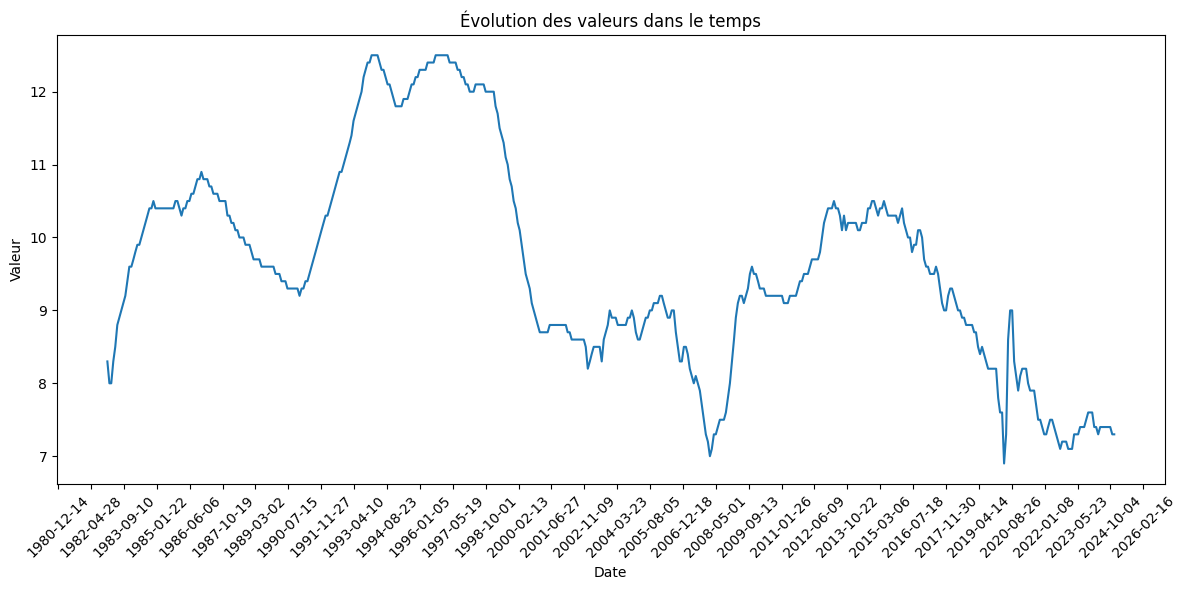

In [12]:
dataset_US = dataset[dataset["REF_AREA"] == pays]
dataset_US.loc[:, 'TIME_PERIOD'] = pd.to_datetime(dataset_US["TIME_PERIOD"])
dataset_US = dataset_US.sort_values(by='TIME_PERIOD')

plt.figure(figsize=(12, 6))
plt.plot(dataset_US['TIME_PERIOD'], dataset_US['OBS_VALUE'])
plt.xlabel('Date')
plt.ylabel('Valeur')
plt.title('Évolution des valeurs dans le temps')
plt.xticks(rotation=45)

# Formatage auto de l'axe x
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(40))  # max 10 dates visibles
plt.tight_layout()
plt.show()

# Split Trainign/Test

In [71]:
from torch.utils.data import DataLoader

pays = "FRA"
prop = [0.7, 0.15, 0.15]
scaler=MinMaxScaler()
seq_len = 6
shift = 1

train_data, val_data, test_data = extract_data(dataset, pays, prop, scaler=scaler)
dataset_train = UnemployRateDataset(train_data, seq_len=seq_len, shift=shift)
train_dataloader = DataLoader(dataset_train, batch_size=32, shuffle=True)

In [ ]:
from torch import nn
import torch.optim as optim
import train_plot

DEVICE = "cuda"

model = HybridLSTMGRU().to(DEVICE)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 1500
train_plot.metric_start_plot()
for epoch in range(EPOCHS):
    model.train()
    for X, y in train_dataloader:
        X = X.unsqueeze(-1).to(DEVICE)
        y = y.unsqueeze(-1).to(DEVICE)
        
        optimizer.zero_grad()
        output = model(X)
        loss = criterion(output, y)
        loss.backward()
        optimizer.step()
        
    if (epoch-1) % 100 == 0:
        #train_plot.metric_plot_values(model, train_data, val_data, seq_len, scaler, epoch)
        train_rmse, train_mae, train_mape = eval.evaluate(model, train_data, None, seq_len, scaler)
        val_rmse, val_mae, val_mape = eval.evaluate(model, val_data, train_data, seq_len, scaler)
        print(f"Epoch {epoch}/{EPOCHS}")
        print(f"Training - RMSE: {train_rmse:.4f},  MAE: {train_mae:.4f}, MAPE: {train_mape:.4f}")
        print(f"Validation - RMSE: {val_rmse:.4f},  MAE: {val_mae:.4f}, MAPE: {val_mape:.4f}")
    
train_plot.metric_end_plot()

Epoch 1/1500
Training - RMSE: 1.2417,  MAE: 0.9918, MAPE: 0.0966
Validation - RMSE: 0.4873,  MAE: 0.4390, MAPE: 0.0438
Epoch 101/1500
Training - RMSE: 0.1194,  MAE: 0.0926, MAPE: 0.0097
Validation - RMSE: 0.1555,  MAE: 0.1274, MAPE: 0.0129
Epoch 201/1500
Training - RMSE: 0.0869,  MAE: 0.0634, MAPE: 0.0067
Validation - RMSE: 0.1184,  MAE: 0.0948, MAPE: 0.0096
Epoch 301/1500
Training - RMSE: 0.0805,  MAE: 0.0601, MAPE: 0.0063
Validation - RMSE: 0.1119,  MAE: 0.0885, MAPE: 0.0089
Epoch 401/1500
Training - RMSE: 0.0796,  MAE: 0.0603, MAPE: 0.0063
Validation - RMSE: 0.1107,  MAE: 0.0877, MAPE: 0.0088
Epoch 501/1500
Training - RMSE: 0.0819,  MAE: 0.0636, MAPE: 0.0067
Validation - RMSE: 0.1123,  MAE: 0.0888, MAPE: 0.0089
Epoch 601/1500
Training - RMSE: 0.0800,  MAE: 0.0587, MAPE: 0.0062
Validation - RMSE: 0.1117,  MAE: 0.0886, MAPE: 0.0089
Epoch 701/1500
Training - RMSE: 0.0803,  MAE: 0.0605, MAPE: 0.0063
Validation - RMSE: 0.1114,  MAE: 0.0885, MAPE: 0.0089
Epoch 801/1500
Training - RMSE: 0.

Test - RMSE: 1.4761,  MAE: 0.7539, MAPE: 0.1367
Naive - RMSE: 1.2721,  MAE: 0.3526, MAPE: 0.0464


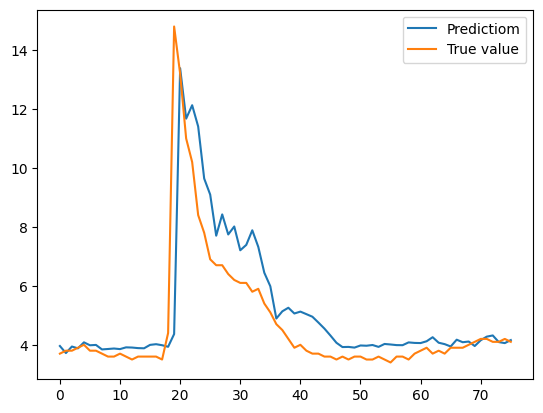

In [ ]:

test_rmse, test_mae, test_mape = eval.evaluate(model, test_data, val_data, seq_len, scaler)
naive_rmse, naive_mae, naive_mape = eval.evaluate_naive(test_data, val_data, seq_len, scaler)

print(f"Test - RMSE: {test_rmse:.4f},  MAE: {test_mae:.4f}, MAPE: {test_mape:.4f}")
print(f"Naive - RMSE: {naive_rmse:.4f},  MAE: {naive_mae:.4f}, MAPE: {naive_mape:.4f}")

eval.plot_prediction(model, test_data, val_data, seq_len, scaler)
